[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/aapi_2025/blob/main/segmentation.ipynb)

# Example of UNET for segmenting pets

A popular example of using a U-Net architecture for image segmentation is in segmenting pets, such as cats and dogs, from their backgrounds. U-Net, a convolutional neural network (CNN) designed specifically for biomedical image segmentation, can be applied effectively in this scenario due to its encoder-decoder structure. In the encoder path, the network captures the context and spatial features of the image through downsampling layers, while the decoder path restores the spatial resolution using upsampling, allowing precise localization of the segmented regions. By training the U-Net model on a dataset of pet images with annotated masks, the network learns to distinguish pets from the background accurately, even in complex scenes with various poses, lighting, and textures. 

The dataset used for training the network is a reduced version of Oxford-IIIT Pet Dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/). The dataset, including the pretrained model, can be downloaded from: https://upm365-my.sharepoint.com/:f:/g/personal/angelmario_garcia_upm_es/EpZ2AipYtmZLrt7l1C9d1Z4Bysm3BYPpRBhjInwfboePFA?e=zTB7RX


In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as optim
from tqdm import tqdm

###  Definition of Unet class

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )
            return block

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv_final(dec1)

### Definition of Dataset class

In [3]:
class PetsDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_paths = sorted(glob(os.path.join(img_dir, '*.jpg')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))  # Resize to 128x128 for efficiency

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
        mask = ((mask==1) + (mask==3)) # Mask contaings 3 possible values (1: object, 2: background, 3: contour of object) 
        mask = np.expand_dims(mask, axis=0)
        
        img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask

### Create a DataLoader

In [4]:
img_dir = 'images/'  # Path to the images
mask_dir = 'masks/'  # Path to the masks
dataset = PetsDataset(img_dir, mask_dir)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=1).to(device)

# If pretrained model doesn't exist then train
if not os.path.exists('unet_model.pth'):
    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Use Binary Cross-Entropy Loss for binary segmentation
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 20
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
    
        for imgs, masks in data_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
    
            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, masks)
    
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader)}")
        
    torch.save(model.state_dict(), 'unet_model.pth')
else:
    model.load_state_dict(torch.load('unet_model.pth', weights_only=True))

### Visualize some results on train set

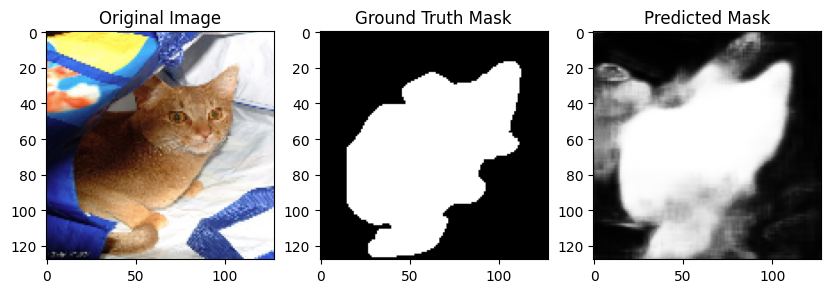

In [6]:
def visualize_sample(model, dataset, index):
    model.eval()
    img, mask = dataset[index]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(img)

    pred_mask = torch.sigmoid(pred_mask).cpu().numpy()[0, 0]
    
    # Plotting the original image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(np.transpose(img.cpu().numpy()[0], (1, 2, 0)))
    ax[0].set_title("Original Image")
    
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title("Predicted Mask")

    plt.show()


visualize_sample(model, dataset, 2)

### Visualize some results on test set

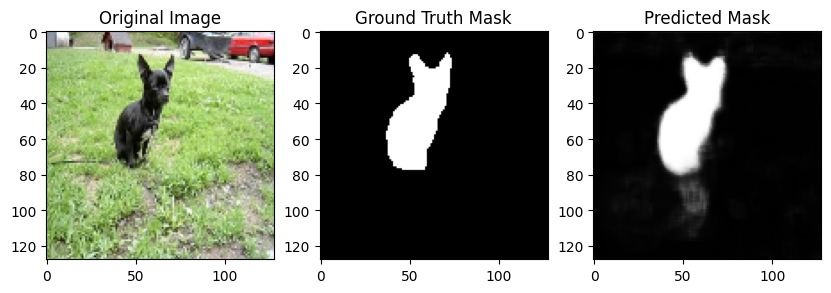

In [7]:
img_dir = 'images_test/'
mask_dir = 'masks_test/' 
dataset = PetsDataset(img_dir, mask_dir)

visualize_sample(model, dataset, 18)